In [31]:
#Results and Explanation

# THE BEST MODEL: Voting Classifier (Top 5 Models)
# The Models Used were:
# 1. Smote with XGBoost
# 2. Cost Sensitive Random Forest
# 3. Cost Sensitive Extra Trees
# 4. XGBoost
# 5. Smote with Random Forest

#Best Mean Cross Validation Score is 0.868811711423656
#Best Mean Cross Validation Score is {'voting': 'soft'}
#Train score is 0.9413707679603632
#Test Score is 0.835 (Kaggle Submission Score)

#THE SECOND BEST MODEL
#Cost Sensitive Random Forest
# Best Cross Validation Score: 0.85
# Best Parameters: class_weight='balanced',max_depth=4,n_estimators=50
# Train Score : 0.87
# Test Score : 0.83035
# Generally Cost Sensitive algorihms tend to work well with imbalanced datasets

#Performance metrics used : F2 score

#THIRD BEST MODEL: Logistic Regression using Stacking Classifier
# The ensemble of models used within this stacking Classifier were
# 1. Cost Sensitive Decision Trees
# 2. Cost Sensitive Extra Trees
# 3. Cost Sensitive Random Forest
# 4. Cost Sensitive XGboost
#Best Cross Validation Score: 0.86
#Best Mean Cross Validation parameters are:
#'final_estimator__C': 10, 'final_estimator__class_weight': {0: 1, 1: 10}, 'stack_method': 'auto'
# Train score is 0.928
# Test Score (From Kaggle submission) is 0.8288

# FOURTH BEST MODEL: Random Forest with SMOTE
# Best Cross Validation Score: 0.85
# Best Parameters: n_estimators=50,criterion='entropy', max_features='log2',max_depth=4
# Train Score : 0.863
# Test Score : 0.82446


# STEPS FOR FEATURE SCALING
# I observed that some variables have gaussian distribution whereas other variables do not. For instance variables such as
# V1, V18, V24, V25, V26 do not seem to have a gaussian distribution whereas V13, V15,V18,V19 seem to somewhat 
# resemble a gaussian distribution
# We also notice that a large majority of the variables are skewed

#1. Used the arbitrary missing value imputer to fill the missing values with a number less than the min number
#   in both the columns to distinguish the NaN values from the rest of the values in the dataset
#2. Used the power transformer (YeoJohnsonTransformer because the variables have both positive and negative values) 
#   on the variables to make the data more gaussian like and also apply zero-mean, unit variance normalization 
#   to the transformed output
#3. Used Robust Scaler on the variables since scaling statistics of this scaler are based on percentiles
#   and are therefore not influenced by a few number of very large marginal outliers


# LIST OF NEW THINGS IMPLEMENTED:
# 1. Random Search Cross Validation; I used this technique to randomly search parameters with Light GBM: 
#    Random Search is used to set up a grid of hyperparameter values and select random combinations to train 
#    the model and score. 
#    The number of search iterations is set based on time/resources
# 2. Light GBM : This gradient boosting algorithm uses tree based learning having higher speed and ability to deal
#    with large datasets
# 3. LDA; Linear Discriminant Analysis: This is a classifier with a linear decision boundary 
#    generated by fitting class conditional densities to the data and using Bayes’ rule.

# GENERAL OBSERVATIONS:
#1. Generally I realized that Random Forest which is essentially a combination of decision trees and bagging  
#   performed better in terms of reducing model overfitting and generating robust results

#2. The Neural Network MLP Classifier also performed fairly well: Unlike other algorithms MLPClassifier relies 
#   on an underlying Neural Network to perform the task of classification. 

#3. Reducing the max_depth of the trees and adjusting the learning rate can help reduce overfitting within the models.
#   Increasing the depth within the model can generally lead to more overfitting
 
#4. Xgboost was more prone to overfitting than the other models within the dataset; Adjusted the learning rate and depth
#   to between 0.1-0.5 however each iteration took a long time to run making it difficult to experiment with all
#   combintaions of hyperparameters

#5. Tried working with Gaussian Process Classifier however the kernel slowed down extensibly because it was 
#   computationally extensive in terms of memory


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# for the Q-Q plots
import scipy.stats as stats
%matplotlib inline

In [2]:
data = pd.read_csv('train_project2.csv')

In [5]:
data.head()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
0,138662,-0.711273,1.272483,1.681631,0.039897,-0.312381,-1.161083,0.853875,-0.173979,-0.438558,...,-0.208181,-0.414631,0.057957,0.930321,-0.165598,0.038799,0.384295,0.192762,21.87,0
1,235999,1.990679,-0.128465,-1.700556,0.529839,0.136889,-1.404270,0.593353,-0.456700,0.648260,...,0.018179,0.179084,-0.004248,0.039531,0.333765,-0.225201,-0.047285,-0.059682,49.99,0
2,245376,1.812653,-0.476162,-0.338988,1.386750,-0.745965,-0.449870,-0.492226,0.029904,1.129394,...,0.252668,0.655719,0.090057,-0.136884,-0.172452,-0.556921,0.036490,-0.021575,79.00,0
3,202483,-1.014219,0.522775,-0.337978,-1.957797,3.578395,3.266965,0.602857,0.644645,-0.305879,...,0.147742,0.590740,-0.680551,0.745346,1.119496,0.013520,0.004530,-0.132643,6.00,0
4,9710,-0.967270,-0.053815,2.273463,-0.894434,0.728924,0.153524,-0.038330,0.165252,1.172526,...,0.106692,0.514430,-0.081546,-0.305042,-0.354883,0.896254,-0.182293,-0.142810,15.95,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24846 entries, 0 to 24845
Data columns (total 31 columns):
Id        24846 non-null int64
V1        22459 non-null float64
V2        24846 non-null float64
V3        24846 non-null float64
V4        24846 non-null float64
V5        24846 non-null float64
V6        24846 non-null float64
V7        24846 non-null float64
V8        24846 non-null float64
V9        24846 non-null float64
V10       24846 non-null float64
V11       24846 non-null float64
V12       24846 non-null float64
V13       24846 non-null float64
V14       24846 non-null float64
V15       24846 non-null float64
V16       24846 non-null float64
V17       24846 non-null float64
V18       24846 non-null float64
V19       24846 non-null float64
V20       22317 non-null float64
V21       24846 non-null float64
V22       24846 non-null float64
V23       24846 non-null float64
V24       24846 non-null float64
V25       24846 non-null float64
V26       24846 non-null float64
V2

In [20]:
#Checking the number of missing observations by target category 1 (Minority Class)
#We observe that the data is missing in only two variables; V1 and V20

df = data[data['Target']==1].count()/len(data[data['Target']==1])
df

Id        1.000000
V1        0.872951
V2        1.000000
V3        1.000000
V4        1.000000
V5        1.000000
V6        1.000000
V7        1.000000
V8        1.000000
V9        1.000000
V10       1.000000
V11       1.000000
V12       1.000000
V13       1.000000
V14       1.000000
V15       1.000000
V16       1.000000
V17       1.000000
V18       1.000000
V19       1.000000
V20       0.877049
V21       1.000000
V22       1.000000
V23       1.000000
V24       1.000000
V25       1.000000
V26       1.000000
V27       1.000000
V28       1.000000
V29       1.000000
Target    1.000000
dtype: float64

In [19]:
#Check the number of missing observations by Target category 0 (Majority Class)
#We observe that the data is missing for the two same variables here as well; V1 and V20
df1 = data[data['Target']==0].count()/len(data[data['Target']==0])
df1

Id        1.000000
V1        0.904235
V2        1.000000
V3        1.000000
V4        1.000000
V5        1.000000
V6        1.000000
V7        1.000000
V8        1.000000
V9        1.000000
V10       1.000000
V11       1.000000
V12       1.000000
V13       1.000000
V14       1.000000
V15       1.000000
V16       1.000000
V17       1.000000
V18       1.000000
V19       1.000000
V20       0.898423
V21       1.000000
V22       1.000000
V23       1.000000
V24       1.000000
V25       1.000000
V26       1.000000
V27       1.000000
V28       1.000000
V29       1.000000
Target    1.000000
dtype: float64

In [26]:
#Checking the max and min values in the missing columns

data[['V20','V1']].describe()

,V20,V1
count,22317.000000,22459.000000
mean,0.003860,-0.042032
std,0.832891,2.061469
min,-54.497720,-37.054295
25%,-0.212758,-0.941997
50%,-0.060477,0.002750
75%,0.137391,1.309469
max,17.819507,2.418267


In [33]:
data.describe()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
count,24846.000000,22459.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,...,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000
mean,141868.788095,-0.042032,0.019074,-0.055260,0.029289,-0.031085,-0.008175,-0.026007,0.014152,-0.017939,...,0.004708,0.006116,-0.004320,-0.005632,0.003193,0.001730,0.003160,-0.000100,91.698618,0.009820
std,82016.035976,2.061469,1.722647,1.730072,1.482053,1.616062,1.413044,1.620777,1.236557,1.140772,...,0.753043,0.728869,0.622440,0.602507,0.518214,0.483415,0.455299,0.314326,310.349300,0.098613
min,32.000000,-37.054295,-39.818310,-48.325589,-5.231828,-113.743307,-19.996349,-37.060311,-39.688571,-11.126624,...,-21.620120,-8.887017,-23.222016,-2.759942,-4.930750,-1.658162,-7.976100,-15.430084,0.000000,0.000000
25%,70705.000000,-0.941997,-0.611444,-0.918977,-0.853705,-0.705745,-0.778707,-0.565469,-0.207270,-0.659425,...,-0.225318,-0.528751,-0.163086,-0.363609,-0.310198,-0.325839,-0.069698,-0.053829,5.470000,0.000000
50%,141887.000000,0.002750,0.068992,0.163070,-0.006193,-0.070299,-0.279575,0.032157,0.026507,-0.056063,...,-0.026834,0.016988,-0.011396,0.036837,0.020346,-0.049872,0.001493,0.010855,21.990000,0.000000
75%,212513.500000,1.309469,0.825253,1.016704,0.759149,0.598372,0.402585,0.569205,0.335042,0.586035,...,0.192690,0.533115,0.147343,0.433292,0.352613,0.241366,0.093725,0.079364,77.900000,0.000000
max,284781.000000,2.418267,19.167239,3.862590,15.304184,28.762671,73.301626,120.589494,19.587773,8.918202,...,27.202839,8.272233,17.606637,4.584549,4.554683,3.415636,31.612198,15.522649,25691.160000,1.000000


In [28]:
#Checking the distribution of the majority and minority class in Training dataset
from collections import Counter

target = data.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=24602, Percentage=99.018%
Class=1, Count=244, Percentage=0.982%


In [3]:
test = pd.read_csv('test_project2.csv')
test.head()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,83172,-2.033519,-1.079309,1.972553,-1.377534,-0.773444,0.702919,-0.870868,1.082417,-0.789931,...,0.536853,0.300559,0.409305,0.119931,-0.295053,0.331692,-0.277494,0.184017,-0.076897,141.01
1,140094,1.125524,0.189854,1.508660,2.719937,-0.882342,0.128390,-0.622651,0.219444,0.255370,...,-0.225172,-0.097584,-0.172683,0.057556,0.360859,0.265443,-0.040417,0.036686,0.033685,0.00
2,116283,-0.578027,1.109673,1.231751,0.725871,0.139675,-0.030415,0.770472,0.072078,-0.793572,...,0.097561,0.214610,0.773072,-0.110802,0.248029,-0.326140,-0.330373,0.321788,0.198050,43.25
3,222830,1.914017,0.588986,-1.481645,3.515009,1.271977,0.502868,0.536994,-0.055564,-1.452582,...,-0.179258,0.010252,0.020996,0.026001,0.186830,0.288364,-0.004518,-0.073108,-0.063333,30.67
4,60185,1.267642,0.725939,-0.091806,2.370915,0.420349,-0.570252,0.534720,-0.235391,-0.977075,...,-0.172138,-0.052174,-0.176550,-0.161225,-0.123870,0.787280,0.100856,-0.041856,0.004038,1.21


In [32]:
#Checking the distribution of missing values in the Test dataset
test.isnull().sum()/len(test)

Id     0.000000
V1     0.100580
V2     0.000000
V3     0.000000
V4     0.000000
V5     0.000000
V6     0.000000
V7     0.000000
V8     0.000000
V9     0.000000
V10    0.000000
V11    0.000000
V12    0.000000
V13    0.000000
V14    0.000000
V15    0.000000
V16    0.000000
V17    0.000000
V18    0.000000
V19    0.000000
V20    0.100781
V21    0.000000
V22    0.000000
V23    0.000000
V24    0.000000
V25    0.000000
V26    0.000000
V27    0.000000
V28    0.000000
V29    0.000000
dtype: float64

In [87]:
test[['V1','V20']].describe()

,V1,V20
count,22347.000000,22342.000000
mean,-0.031418,-0.003488
std,2.176111,0.806503
min,-46.855047,-23.420173
25%,-0.919228,-0.212470
50%,0.041074,-0.063018
75%,1.318949,0.135580
max,2.422508,23.643417


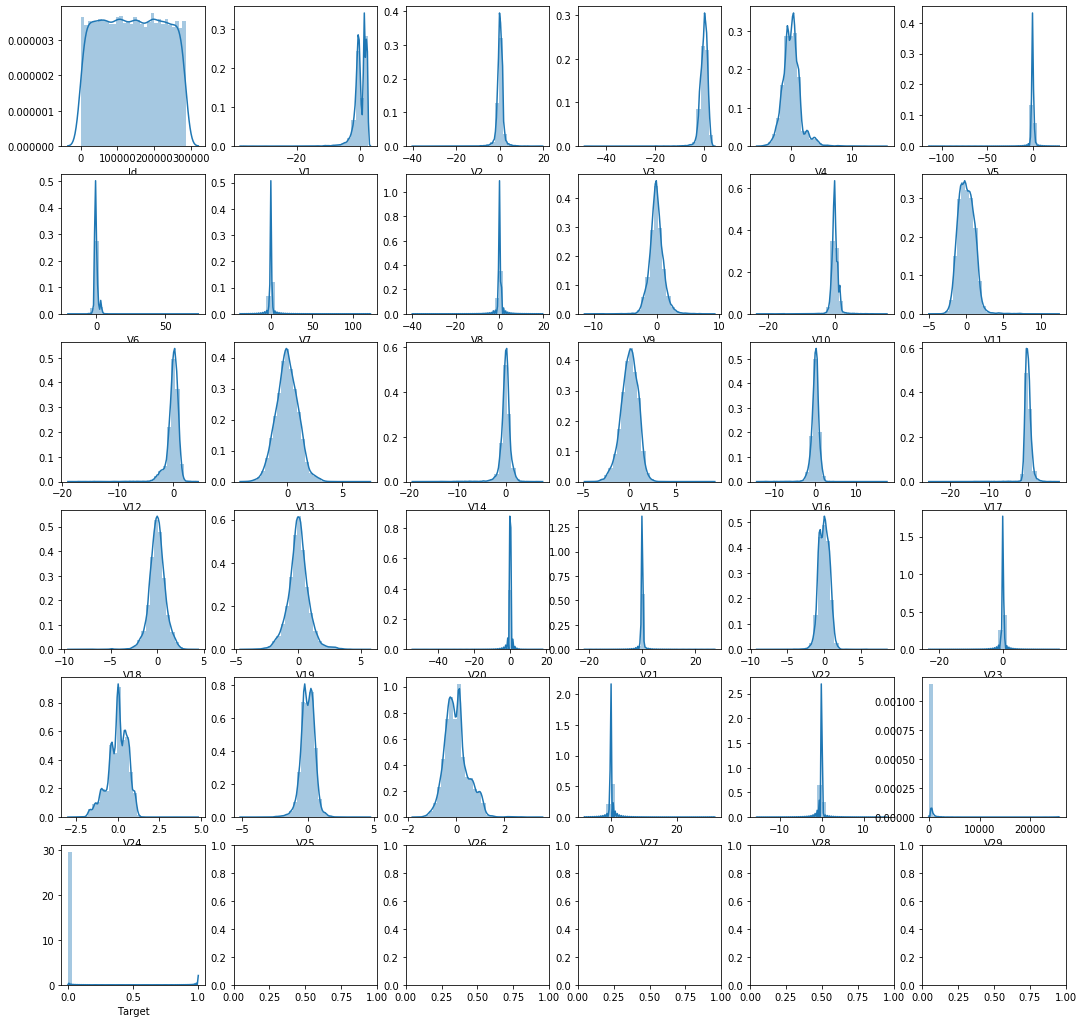

In [36]:
#Checking the variable distribution using histogram- To see if the variables follow normal/gaussian distribution

#We observe that some variables have gaussian distribution whereas other variables do not. For instance variables such as
# V1, V18, V24, V25, V26 do not seem to have a gaussian distribution whereas V13, V15,V18,V19 seem to somewhat 
# resemble a gaussian distribution
# We also notice that a large majority of the variables are skewed

fig, axs = plt.subplots(ncols=6, nrows=6,figsize=(18,18))
axs = axs.flatten()

for i, var in enumerate(data):
    sns.distplot(data[data[var].notnull()][var], bins=30,ax=axs[i]);

((array([-4.02992481, -3.8163647 , -3.69961479, ...,  3.69961479,
          3.8163647 ,  4.02992481]),
  array([-37.05429492, -35.54853921, -34.14823365, ...,          nan,
                  nan,          nan])),
 (nan, nan, nan))

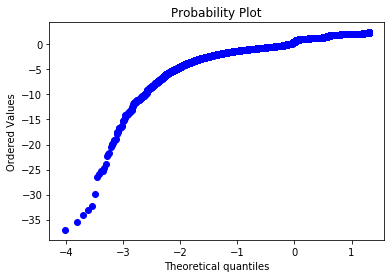

In [43]:
stats.probplot(data['V1'], dist="norm", plot=plt) #Not Normal Distribution

((array([-4.02992481, -3.8163647 , -3.69961479, ...,  3.69961479,
          3.8163647 ,  4.02992481]),
  array([-3.84497361, -3.83561784, -3.69646429, ...,  4.04457709,
          4.0993519 ,  7.12688296])),
 (0.992567722531442, 0.0013621654254613541, 0.9994679665462575))

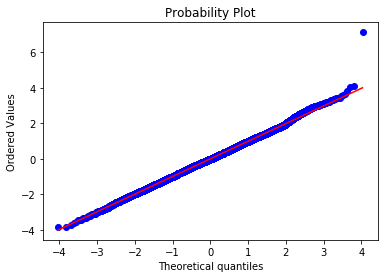

In [55]:
stats.probplot(data['V13'], dist="norm", plot=plt) #Normal Distribution

((array([-4.02992481, -3.8163647 , -3.69961479, ...,  3.69961479,
          3.8163647 ,  4.02992481]),
  array([-54.49772049, -20.09791836, -15.8064758 , ...,          nan,
                  nan,          nan])),
 (nan, nan, nan))

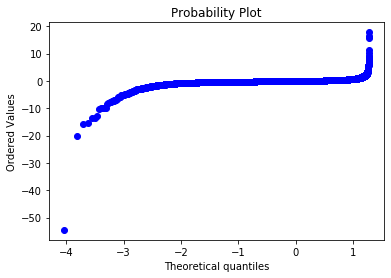

In [72]:
stats.probplot(data['V20'], dist="norm", plot=plt) #Not Normal Distribution

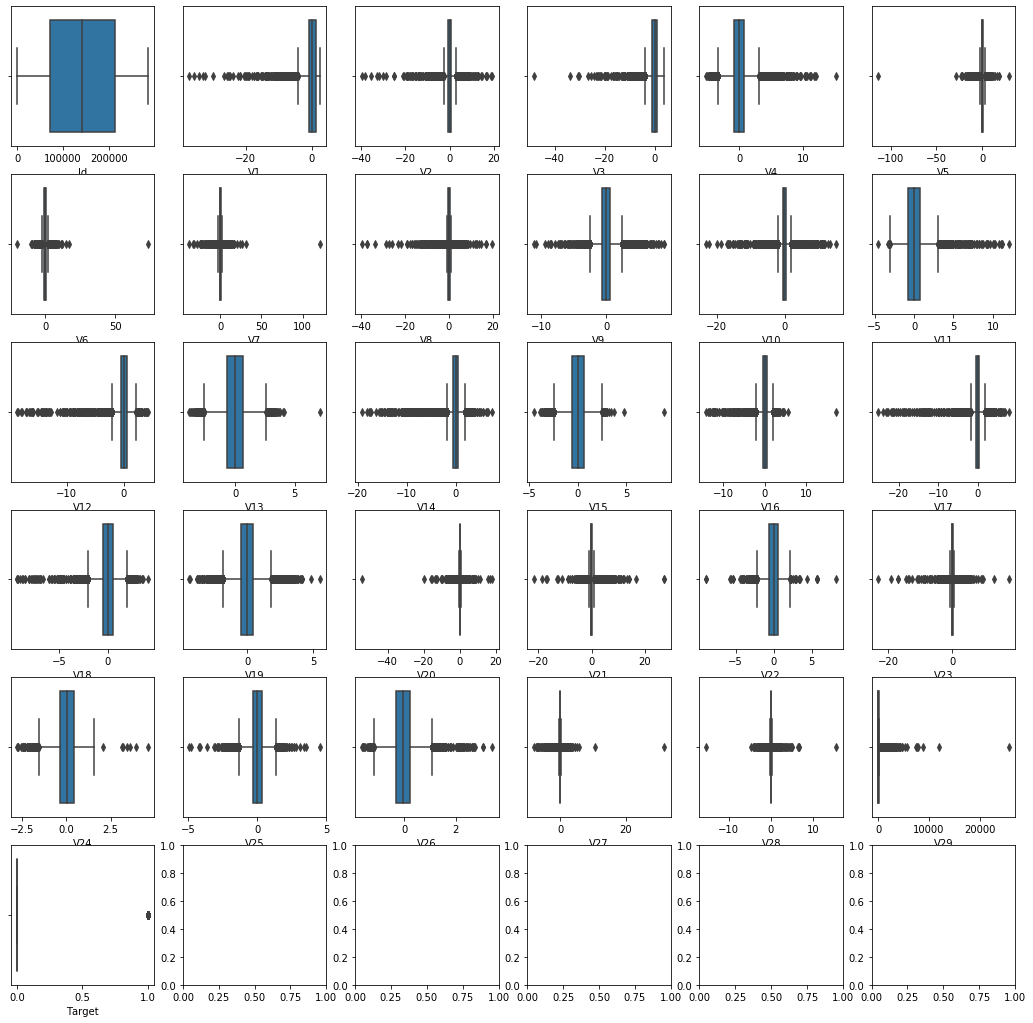

In [73]:
#Checking for outliers within the dataset
#From the plot below we can observe that there is presence of outliers in quite a few variables which need 
#to be taken care of during data preprocessing pipeline by using Robust Scaler

fig, axs = plt.subplots(ncols=6, nrows=6,figsize=(18,18))
axs = axs.flatten()

for i, var in enumerate(data):
    sns.boxplot(data[data[var].notnull()][var], ax=axs[i], orient='h');

In [74]:
#Identifying the outliers within the dataset

def find_boundaries(df, variable, distance):

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)


    return upper_boundary, lower_boundary

In [77]:
data_out = data.drop(['Id','Target'], axis =1)

outliers_dict={}
for var in data_out:
    upper_boundary, lower_boundary = find_boundaries(data, var,1.5)
    outliers = np.where(data_out[var] > upper_boundary, True,
                    np.where(data_out[var] < lower_boundary, True, False))
    outliers_dict[var]=data_out.loc[outliers, var]  
    

In [78]:
for key, value in outliers_dict.items():
    print(key, outliers_dict[key].count(),outliers_dict[key].min(),outliers_dict[key].max())

V1 591 -37.05429492 -4.325002602
V2 1213 -39.81831012 19.16723901
V3 405 -48.32558936 -3.822742266
V4 1034 -5.231827865 15.30418399
V5 1195 -113.7433067 28.76267129
V6 2027 -19.99634854 73.30162555
V7 881 -37.06031146 120.58949390000001
V8 2107 -39.68857108 19.58777262
V9 814 -11.12662352 8.918202354
V10 1016 -23.22825484 15.33174156
V11 182 -4.568390246 12.01891318
V12 1399 -18.68371463 4.242791466
V13 277 -3.844973612 7.126882959
V14 1381 -19.21432549 7.4395655320000005
V15 250 -4.498944677 8.877741598
V16 837 -14.12985452 17.31511152
V17 792 -25.16279937 7.733456284
V18 693 -9.287832214 4.093439956
V19 955 -4.395282985 5.501747214
V20 2198 -54.49772049 17.81950743
V21 1316 -21.62011965 27.20283916
V22 115 -8.887017141 8.272232984
V23 1666 -23.22201631 17.60663686
V24 380 -2.759942203 4.584549137
V25 482 -4.93074976 4.554682756
V26 504 -1.658161935 3.4156362430000002
V27 3484 -7.976099818 31.61219811
V28 2672 -15.43008391 15.52264869
V29 2801 187.0 25691.16


In [80]:
test.shape

(24846, 30)

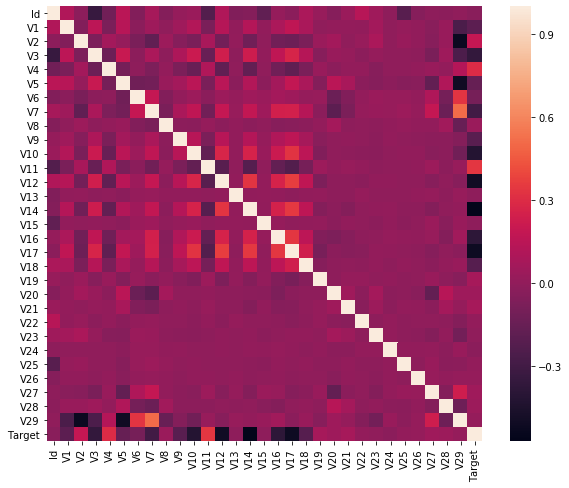

In [81]:
#Producing the heatmap for finding the correlation between the variables
#From the heatmap below we can notice that there is little correlation or less correlation between the variables 

import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),  square=True, ax=ax)


In [4]:
#Defining the X_train and Y_train datasets for evaluation

X_train = data.drop(['Target','Id'], axis=1)
y_train = data['Target']

X_train.shape, y_train.shape

((24846, 29), (24846,))

In [5]:
#Defining the X_test dataset 

X_test=test.drop(['Id'], axis=1)
X_test.shape

(24846, 29)

In [6]:
#Importing packages and libraries for creating the pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine import missing_data_imputers as mdi
from feature_engine.variable_transformers import YeoJohnsonTransformer as YJT
from sklearn.preprocessing import RobustScaler


In [8]:
#Steps for Data Imputation
#1. Used the arbitrary missing value imputer to fill the missing values with a number less than the min number
#   in both the columns to distinguish the NaN values from the rest of the values in the dataset
#2. Used the power transformer (YeoJohnsonTransformer because the variables have both positive and negative values) 
#   on the variables to make the data more gaussian like and also apply zero-mean, unit variance normalization 
#   to the transformed output
#3. Used Robust Scaler on the variables since scaling statistics of this scaler are based on percentiles
#   and are therefore not influenced by a few number of very large marginal outliers

data_preprocess = Pipeline([

    # missing data imputation 
    ('imputer_num_arbit',
     mdi.ArbitraryNumberImputer(arbitrary_number=-70,
                                variables=['V1','V20'])),
    ('power_transform',YJT()),
    ('scale',RobustScaler())
       
])

In [9]:
data_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('imputer_num_arbit',
                 ArbitraryNumberImputer(arbitrary_number=-70,
                                        variables=['V1', 'V20'])),
                ('power_transform',
                 YeoJohnsonTransformer(variables=['V1', 'V2', 'V3', 'V4', 'V5',
                                                  'V6', 'V7', 'V8', 'V9', 'V10',
                                                  'V11', 'V12', 'V13', 'V14',
                                                  'V15', 'V16', 'V17', 'V18',
                                                  'V19', 'V20', 'V21', 'V22',
                                                  'V23', 'V24', 'V25', 'V26',
                                                  'V27', 'V28', 'V29'])),
                ('scale',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True))],
         verbose=False)

In [10]:
# Apply Transformations
X_train=data_preprocess.transform(X_train)
X_test=data_preprocess.transform(X_test)


In [11]:
X_train.shape

(24846, 29)

In [12]:
X_test.shape

(24846, 29)

In [105]:
#MODEL 1

#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

metric = make_scorer(fbeta_score, beta=2)

logreg=LogisticRegression(max_iter=1000, penalty = 'l2')

logreg_param= {'C': [0.001,0.01,0.1,1,10,100]}
logreg_grid = GridSearchCV(logreg, logreg_param,cv=5, return_train_score=True, scoring = metric)
logreg_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [107]:
#Checking the model performance

print(f'Best Mean Cross Validation Score is {logreg_grid.best_score_}')
print(f'Best Parameter is {logreg_grid.best_params_}')
print(f'Train score is {logreg_grid.score(X_train,y_train)}')


Best Mean Cross Validation Score is 0.8088135918107398
Best Parameter is {'C': 1}
Train score is 0.8234295415959253


In [108]:
#Making predictions on test data
predictions_logistic = logreg_grid.predict(X_test)

In [109]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_logistic}).to_csv('solution_file1.csv', index =False)  
print("Done :D")

Done :D


In [14]:
#MODEL 2

#Decision Tree
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

metric = make_scorer(fbeta_score, beta=2)
dtree = DecisionTreeClassifier(random_state=42, max_depth=2,max_leaf_nodes=4,min_samples_split=2)
dtree_param = {
              "splitter": ["best", "random"]}
dtree_grid = GridSearchCV(dtree, dtree_param,cv=5, return_train_score=True, scoring = metric)
dtree_grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=2,
                                              max_features=None,
                                              max_leaf_nodes=4,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'splitter': ['best', 'random']},
             pre_dispatch='2

In [15]:
#Checking the model performance

print(f'Best Mean Cross Validation Score is {dtree_grid.best_score_}')
print(f'Best Parameter is {dtree_grid.best_params_}')
print(f'Train score is {dtree_grid.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.7938827619927201
Best Parameter is {'splitter': 'best'}
Train score is 0.8529411764705882


In [114]:
#Making predictions on test data
predictions_decisiontree = dtree_grid.predict(X_test)

In [115]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_decisiontree}).to_csv('solution_file2.csv', index =False)  
print("Done :D")

Done :D


In [16]:
#MODEL 3
#K Nearest neighbours

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
metric = make_scorer(fbeta_score, beta=2)

# define a list of parameters

param_knn = {'n_neighbors': range(2,4)}


#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=5, return_train_score=True, scoring=metric)
grid_knn.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_))
print()

#find best parameters
print('KNN parameters: ', grid_knn.best_params_)

# Check train data set performance
print("KNN Test Performance: ", grid_knn.score(X_train,y_train))

Best Mean Cross-validation score: 0.78

KNN parameters:  {'n_neighbors': 3}
KNN Test Performance:  0.867003367003367


In [118]:
#Making predictions on test data
predictions_knn = grid_knn.predict(X_test)

In [119]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_knn}).to_csv('solution_file3.csv', index =False)  
print("Done :D")

Done :D


In [17]:
#MODEL 4
#Random Forest

from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=0,max_depth=8,n_estimators=50,max_features='log2')
metric = make_scorer(fbeta_score, beta=2)

rfc_param = { 
   
    'criterion' :['gini', 'entropy']
}

grid_rf = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True, scoring = metric)
grid_rf.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {grid_rf.best_score_}')
print(f'Best Mean Cross Validation Score is {grid_rf.best_params_}')
print(f'Train score is {grid_rf.score(X_train,y_train)}')


Best Mean Cross Validation Score is 0.8494435973808004
Best Mean Cross Validation Score is {'criterion': 'entropy'}
Train score is 0.874894336432798


In [123]:
#Making predictions on test data
predictions_randomforest = grid_rf.predict(X_test)

In [124]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_randomforest}).to_csv('solution_file4.csv', index =False)  
print("Done :D")

Done :D


In [121]:
#MODEL 5
#Extra Trees

from sklearn.ensemble import ExtraTreesClassifier
metric = make_scorer(fbeta_score, beta=2)

etc= ExtraTreesClassifier(random_state=42)
etc_param = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_et = GridSearchCV(etc, etc_param,cv=5, return_train_score=True, scoring =metric )
grid_et.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {grid_et.best_score_}')
print(f'Best Mean Cross Validation Score is {grid_et.best_params_}')
print(f'Train score is {grid_et.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.7139179971849415
Best Mean Cross Validation Score is {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}
Train score is 0.6998239436619719


In [ ]:
#Making predictions on test data
predictions_extratrees = grid_et.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_extratrees}).to_csv('solution_file5.csv', index =False)  
print("Done :D")

In [27]:
#MODEL 6
#Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

metric = make_scorer(fbeta_score, beta=2)
gbc= GradientBoostingClassifier(random_state=42,max_depth=4,learning_rate=0.05)
gbc_param = {
              #'max_depth' : [2,3,4],
              'n_estimators' : [400,500],
              #'learning_rate' : [0.1,0.8,1],
             }
grid_gd = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True,scoring = metric )
grid_gd.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {grid_gd.best_score_}')
print(f'Best Mean Cross Validation Score is {grid_gd.best_params_}')
print(f'Train score is {grid_gd.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8199638916626422
Best Mean Cross Validation Score is {'n_estimators': 500}
Train score is 1.0


In [ ]:
#Making predictions on test data
predictions_gradientboost = grid_gd.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_gradientboost}).to_csv('solution_file6.csv', index =False)  
print("Done :D")

In [28]:
#MODEl 7
#XGBoost

from  xgboost import XGBClassifier
metric = make_scorer(fbeta_score, beta=2)
xgbc= XGBClassifier(early_stopping_rounds=2,random_state=42,n_estimators=5000,learning_rate=0.01,min_child_weight=3,
                   scale_pos_weight=1,max_delta_step=1,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005)
xgbc_param = {
              'max_depth' : [2,3]
             }

grid_xgb = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True,scoring = metric)
grid_xgb.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {grid_xgb.best_score_}')
print(f'Best parameter is {grid_xgb.best_params_}')
print(f'Train score is {grid_xgb.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8500620745590857
Best parameter is {'max_depth': 2}
Train score is 0.9827302631578949


In [159]:
#Making predictions on test data
predictions_xgboost = grid_xgb.predict(X_test)

In [160]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_xgboost}).to_csv('solution_filexg.csv', index =False)  
print("Done :D")

Done :D


In [18]:
#STACKING CLASSIFIER

#top estimators
estimators_ = [('dt',dtree_grid.best_estimator_),
             ('knn',grid_knn.best_estimator_),
            ('rf',grid_rf.best_estimator_)]

#,('xgb',grid_xgb.best_estimator_)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
sclf1 = StackingClassifier(estimators= estimators_
                            , final_estimator=LogisticRegression(random_state=42,max_iter=1000))
sclf1_param = {
              #'final_estimator__class_weight': [{0:1,1:10}, {0:1,1:100}],
              'final_estimator__C' : [0.8,1,10],
              'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True,scoring=metric )
sclf1_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation params is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8253968957569147
Best Mean Cross Validation params is {'final_estimator__C': 10, 'stack_method': 'auto'}
Train score is 0.874894336432798


In [21]:
#Making predictions on test data
predictions_stack3 = sclf1_grid.predict(X_test)

In [22]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_stack3}).to_csv('solution_filestack3.csv', index =False)  
print("Done :D")

Done :D


In [23]:
#COST SENSITIVE ALGORITHMS

In [89]:
#Logistic Cost Sensitive ALgorithm

param_grid = {   
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}
metric = make_scorer(fbeta_score, beta=2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#apply grid search
cgrid_logreg= GridSearchCV(LogisticRegression(solver='lbfgs',max_iter=1000), param_grid, cv=cv, n_jobs=2, scoring=metric)
cgrid_logreg.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_logreg.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_logreg.best_score_))
print(f'Train score is {cgrid_logreg.score(X_train,y_train)}')

Best parameters: {'class_weight': {0: 1, 1: 10}}
Best Mean cross-validation score: 0.82
Train score is 0.8293269230769229


In [131]:
#Making predictions on test data
predictions_clogistic = cgrid_logreg.predict(X_test)

In [132]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_clogistic}).to_csv('solution_file7.csv', index =False)  
print("Done :D")

Done :D


In [86]:
#Cost Sensitive Decision Tree
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

metric = make_scorer(fbeta_score, beta=2)
param_grid = { 
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
   
}

#apply grid search
cgrid_dtree= GridSearchCV(DecisionTreeClassifier(random_state=23,max_depth=4), param_grid, cv=5, n_jobs=2, scoring=metric)
cgrid_dtree.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_dtree.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_dtree.best_score_))
print(f'Train score is {cgrid_dtree.score(X_train,y_train)}')

Best parameters: {'class_weight': {0: 1, 1: 1}}
Best Mean cross-validation score: 0.83
Train score is 0.8719460825610784


In [87]:
#Making predictions on test data
predictions_cdtree = cgrid_dtree.predict(X_test)

In [24]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_cdtree}).to_csv('solution_filecdt.csv', index =False)  
print("Done :D")

Done :D


In [30]:
#Cost Sensitive XGBoost
from  xgboost import XGBClassifier
param_grid = { 
    'scale_pos_weight': [1,10,15],
    #'max_depth': [3,4,5,6],
    #'learning_rate':[0.1,0.5,1]
}
metric = make_scorer(fbeta_score, beta=2)

#apply grid search
cgrid_xgboost= GridSearchCV(XGBClassifier(random_state=42,early_stopping_rounds=2,min_child_weight=1,n_estimators=5000,max_depth=3,learning_rate=0.03,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005),
                            param_grid, cv=5, n_jobs=2, scoring=metric)
cgrid_xgboost.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_xgboost.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_xgboost.best_score_))
print(f'Train score is {cgrid_xgboost.score(X_train,y_train)}')


Best parameters: {'scale_pos_weight': 10}
Best Mean cross-validation score: 0.85
Train score is 1.0


In [138]:
#Making predictions on test data
predictions_cxgboost = cgrid_xgboost.predict(X_test)

In [139]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_cxgboost}).to_csv('solution_file9.csv', index =False)  
print("Done :D")

Done :D


In [71]:
#Cost Sensitive Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

metric = make_scorer(fbeta_score, beta=2)

rf = RandomForestClassifier(random_state=42, class_weight='balanced',max_depth=4)
param_grid={#'max_depth':[2,3,4],
            'n_estimators': [100,200]  
}

cgrid_crf= GridSearchCV(rf, param_grid, cv=5, n_jobs=2, scoring=metric)
cgrid_crf.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_crf.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_crf.best_score_))
print(f'Train score is {cgrid_crf.score(X_train,y_train)}')


Best parameters: {'n_estimators': 100}
Best Mean cross-validation score: 0.85
Train score is 0.8732737611697808


In [72]:
#Making predictions on test data
predictions_crf = cgrid_crf.predict(X_test)

In [73]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_crf}).to_csv('solution_filecrf.csv', index =False)  
print("Done :D")

Done :D


In [91]:
#Cost Sensitive Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

metric = make_scorer(fbeta_score, beta=2)
et = ExtraTreesClassifier(random_state=42, class_weight='balanced',max_depth=5)
param_grid={
            #'max_depth': [3,4,5],
             'n_estimators':[100,200]   
            }

cgrid_cet= GridSearchCV(et, param_grid, cv=5, n_jobs=2, scoring=metric)
cgrid_cet.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_cet.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_cet.best_score_))
print(f'Train score is {cgrid_cet.score(X_train,y_train)}')


Best parameters: {'n_estimators': 200}
Best Mean cross-validation score: 0.86
Train score is 0.8693843594009982


In [27]:
#Making predictions on test data
predictions_cet = cgrid_cet.predict(X_test)

In [28]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_cet}).to_csv('solution_filecet.csv', index =False)  
print("Done :D")

Done :D


In [29]:
#Bagging decision tree with Undersampling

from imblearn.ensemble import BalancedBaggingClassifier

metric = make_scorer(fbeta_score, beta=2)

b_dtree = BalancedBaggingClassifier(random_state=42)

param_grid={
           'n_estimators':[100,150]
}

cgrid_cbag= GridSearchCV(b_dtree, param_grid, cv=5, n_jobs=2, scoring=metric)
cgrid_cbag.fit(X_train, y_train)

print("Best parameters: {}".format(cgrid_cbag.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_cbag.best_score_))
print(f'Train score is {cgrid_cbag.score(X_train,y_train)}')


Best parameters: {'n_estimators': 150}
Best Mean cross-validation score: 0.65
Train score is 0.7274895646988669


In [30]:
#STACKING CLASSIFIER - Top estimators
#top estimators
estimators_ = [('cs_dtree',cgrid_dtree.best_estimator_),
            ('cs_xgboost',cgrid_xgboost.best_estimator_),('cs_randomforest',cgrid_crf.best_estimator_),
            ('cs_extratrees',cgrid_cet.best_estimator_)]

In [34]:
#STACKING CLASSIFIER
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
sclf1 = StackingClassifier(estimators= estimators_
                            , final_estimator=LogisticRegression(random_state=42,max_iter=1000))
sclf1_param = {
              'final_estimator__class_weight': [{0:1,1:10}, {0:1,1:100}],
              'final_estimator__C' : [0.8,1,10],
              'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True,scoring=metric )
sclf1_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation params is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8616537930303781
Best Mean Cross Validation params is {'final_estimator__C': 10, 'final_estimator__class_weight': {0: 1, 1: 10}, 'stack_method': 'auto'}
Train score is 0.9283387622149838


In [36]:
#Making predictions on test data
predictions_stacking = sclf1_grid.predict(X_test)

In [37]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_stacking}).to_csv('solution_filestackc.csv', index =False)  
print("Done :D")

Done :D


In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [142]:
!pip install imblearn

In [169]:
#SMOTE with Logistic Regression

metric = make_scorer(fbeta_score, beta=2)
pipe_roc_lg = Pipeline([('smote',SMOTE()),('lg',LogisticRegression(max_iter=1000))])
param_roc_lg = {'smote__k_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ogrid_lg= GridSearchCV(pipe_roc_lg,param_roc_lg, cv=cv, n_jobs=2, scoring=metric)
ogrid_lg.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_lg.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_lg.best_score_))
print(f'Train score is {ogrid_lg.score(X_train,y_train)}')

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.57
Train score is 0.604221635883905


In [ ]:
#Making predictions on test data
predictions_slogistic = ogrid_lg.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_slogistic}).to_csv('solution_file12.csv', index =False)  
print("Done :D")

In [152]:
#SMOTE with Decision Tree

metric = make_scorer(fbeta_score, beta=2)

pipe_roc_dtree = Pipeline([('smote',SMOTE()),('dtree',DecisionTreeClassifier())])
param_roc_dtree = {'smote__k_neighbors': [1,2,3,4,5],
                    'max_depth': [2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ogrid_dtree= GridSearchCV(pipe_roc_dtree,param_roc_dtree, cv=cv, n_jobs=2, scoring=metric)
ogrid_dtree.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_dtree.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_dtree.best_score_))
print(f'Train score is {ogrid_dtree.score(X_train,y_train)}')

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.69
Train score is 0.7657657657657658


In [ ]:
#Making predictions on test data
predictions_sdtree = ogrid_dtree.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_sdtree}).to_csv('solution_file13.csv', index =False)  
print("Done :D")

In [39]:
#SMOTE with XGBoost
metric = make_scorer(fbeta_score, beta=2)
pipe_roc_xgb = Pipeline([('smote',SMOTE()),('xgb',XGBClassifier(random_state=42,
                                                                            early_stopping_rounds=2,
                                                                            n_estimators=140,
                                                                            objective ='binary:logistic',
                                                                            max_depth = 3,learning_rate=0.3
                                                                             ))])
param_roc_xgb = {'smote__k_neighbors': [1,2,3,4,5],
                 'xgb__scale_pos_weight': [1,10,15],
                }

ogrid_xgb= GridSearchCV(pipe_roc_xgb,param_roc_xgb, cv=5, n_jobs=2, scoring=metric)
ogrid_xgb.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_xgb.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_xgb.best_score_))

Best parameters: {'smote__k_neighbors': 1, 'xgb__scale_pos_weight': 10}
Best Mean cross-validation score: 0.86


In [40]:
print(f'Train score is {ogrid_xgb.score(X_train,y_train)}')

Train score is 0.996732026143791


In [172]:
#Making predictions on test data
predictions_sxgboost = ogrid_xgb.predict(X_test)

In [173]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_sxgboost}).to_csv('solution_fileSxgb2.csv', index =False)  
print("Done :D")

Done :D


In [42]:
#SMOTE with KNN

metric = make_scorer(fbeta_score, beta=2)
pipe_roc_knn = Pipeline([('smote',SMOTE()),('knn',KNeighborsClassifier(n_neighbors=3))])
param_roc_knn = {'smote__k_neighbors': [1,2,3,4,5]}

ogrid_knn= GridSearchCV(pipe_roc_knn,param_roc_knn, cv=5, n_jobs=2, scoring=metric)
ogrid_knn.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_knn.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_knn.best_score_))

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.80


In [43]:
print(f'Train score is {ogrid_knn.score(X_train,y_train)}')

Train score is 0.9591194968553459


In [ ]:
#Making predictions on test data
predictions_sknn = ogrid_knn.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_sknn}).to_csv('solution_filesknn.csv', index =False)  
print("Done :D")

In [61]:
#SMOTE with random forest

pipe_roc_rf = Pipeline([('smote',SMOTE()),('rf',RandomForestClassifier(random_state=42,n_estimators=50,criterion='entropy',
                                                                       max_features='log2',max_depth=4))])
param_roc_rf = {'smote__k_neighbors': [2,3]
                }

ogrid_rf= GridSearchCV(pipe_roc_rf,param_roc_rf, cv=5, n_jobs=2, scoring=metric)
ogrid_rf.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_rf.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_rf.best_score_))

Best parameters: {'smote__k_neighbors': 2}
Best Mean cross-validation score: 0.85


In [63]:
print(f'Train score is {ogrid_rf.score(X_train,y_train)}')

Train score is 0.8633387888707036


In [176]:
#Making predictions on test data
predictions_srf = ogrid_rf.predict(X_test)

In [177]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_srf}).to_csv('solution_filesrf.csv', index =False)  
print("Done :D")

Done :D


In [48]:
#easy ensemble classifier
from imblearn.ensemble import EasyEnsembleClassifier
pipe_roc_ee = Pipeline([('smote',SMOTE()),('ee',EasyEnsembleClassifier(random_state=42))])
param_roc_ee = {'smote__k_neighbors': [1,2,3,4,5]}

ogrid_ee= GridSearchCV(pipe_roc_ee,param_roc_ee, cv=5, n_jobs=2, scoring=metric)
ogrid_ee.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_ee.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_ee.best_score_))

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.69


In [49]:
print(f'Train score is {ogrid_ee.score(X_train,y_train)}')

Train score is 0.7178683385579937


In [ ]:
#Making predictions on test data
predictions_srf = ogrid_rf.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_srf}).to_csv('solution_filesrf.csv', index =False)  
print("Done :D")

In [49]:
#top estimators
estimators_ = [('mlp',ogrid_mlp.best_estimator_),
            ('smote random forest',ogrid_rf.best_estimator_),('lgb',rgrid_gbdt.best_estimator_),
             ]

In [50]:
from sklearn.ensemble import StackingClassifier
sclf2 = StackingClassifier(estimators= estimators_
                            , final_estimator=LogisticRegression(max_iter=1000,random_state=42))
sclf2_param = {
              'final_estimator__C' : [0.1,0.5,1,10],
              'stack_method':['auto']
             }
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True,scoring=metric )
sclf2_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation params is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
#print(f'Test score is {sclf2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8553064715993782
Best Mean Cross Validation params is {'final_estimator__C': 10, 'stack_method': 'auto'}
Train score is 0.9276206322795341


In [51]:
#Making predictions on test data
predictions_stacking2 = sclf2_grid.predict(X_test)

In [52]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_stacking2}).to_csv('solution_filestack2.csv', index =False)  
print("Done :D")

Done :D


In [50]:
from sklearn.neural_network import MLPClassifier

In [52]:
# SMOTE with MLP Classifier

pipe_f2_mlp = Pipeline([('smote',SMOTE()),('mlp',MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1))])
param_f2_mlp = {'smote__k_neighbors': [4,5]}


ogrid_mlp= GridSearchCV(pipe_f2_mlp,param_f2_mlp, cv=5, n_jobs=2, scoring=metric)
ogrid_mlp.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_mlp.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_mlp.best_score_))

Best parameters: {'smote__k_neighbors': 5}
Best Mean cross-validation score: 0.85


In [53]:
print(f'Train score is {ogrid_mlp.score(X_train,y_train)}')

Train score is 0.9910641754670998


In [185]:
#Making predictions on test data
predictions_mlp = ogrid_mlp.predict(X_test)

In [186]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_mlp}).to_csv('solution_filemlp.csv', index =False)  
print("Done :D")

Done :D


In [55]:
#LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe_f2_lda = Pipeline([('smote',SMOTE()),('lda', LinearDiscriminantAnalysis())])
param_f2_lda = {'smote__k_neighbors': [1,2,3,4,5]}


ogrid_lda= GridSearchCV(pipe_f2_lda,param_f2_lda, cv=5, n_jobs=2, scoring=metric)
ogrid_lda.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_lda.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_lda.best_score_))

Best parameters: {'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.67


In [56]:
print(f'Train score is {ogrid_lda.score(X_train,y_train)}')

Train score is 0.6756756756756758


In [189]:
!pip install lightgbm

In [65]:
import lightgbm as lgb

In [67]:
# Light GBM with RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',random_state = 42)

param_grid = {
     #'subsample':[i/10.0 for i in range(6,10)],
     
    # 'colsample_bytree':[i/10.0 for i in range(6,10)]
    'max_depth': [2,3],
    'num_leaves': range(20, 150),
    'learning_rate': [0.1,0.3],
    'subsample_for_bin': range(20000, 300000, 20000),
    'min_child_samples': range(20, 500, 5),
    'reg_alpha': [0,0.001, 0.1,0.5,1],
    'reg_lambda': [0,0.001, 0.1,0.5,1],
    'colsample_bytree':[i/10.0 for i in range(5,10)] ,
    'subsample': [i/10.0 for i in range(6,10)],
    'is_unbalance': [True, False]
}

rgrid_gbdt = RandomizedSearchCV(model, param_grid,cv=5, return_train_score=True,scoring = metric)
rgrid_gbdt.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {rgrid_gbdt.best_score_}')
print(f'Best parameter is {rgrid_gbdt.best_params_}')
print(f'Train score is {rgrid_gbdt.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8290876137423234
Best parameter is {'subsample_for_bin': 20000, 'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 54, 'min_child_samples': 435, 'max_depth': 3, 'learning_rate': 0.1, 'is_unbalance': False, 'colsample_bytree': 0.5}
Train score is 0.8904682274247493


In [68]:
#Making predictions on test data
predictions_lgb = rgrid_gbdt.predict(X_test)

In [69]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_lgb}).to_csv('solution_filelgb1.csv', index =False)  
print("Done :D")

Done :D


In [84]:
#Bagging with Decision tree

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


bag_dtree2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth= 4, max_leaf_nodes=4, min_samples_split= 2, splitter= 'best'), bootstrap=True, random_state=0, oob_score=True)

bag_dtree2_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100],
                'base_estimator__class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}
bag_dtree2_grid = GridSearchCV(bag_dtree2, bag_dtree2_param,cv=5, return_train_score=True,scoring=metric )
bag_dtree2_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {bag_dtree2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree2_grid.best_params_}')
print('train score: ', bag_dtree2_grid.score(X_train,y_train))

Best Mean Cross Validation Score is 0.8418174397711755
Best Mean Cross Validation Score is {'base_estimator__class_weight': {0: 1, 1: 1}, 'max_samples': 0.8, 'n_estimators': 10}
train score:  0.8564231738035265


In [98]:
#Making predictions on test data
predictions_bagdtree = bag_dtree2_grid.predict(X_test)

In [99]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_bagdtree}).to_csv('solution_filebagdtree.csv', index =False)  
print("Done :D")

Done :D


In [92]:
#Summary of the models run

classifiers={'CS_decision tree': cgrid_dtree,
             'S_xgb':ogrid_xgb,
             'easy ensemble':ogrid_ee,
             'KNN': grid_knn,
             'mlp': ogrid_mlp,
             'CS_LogisticRegression':cgrid_logreg,
             'bag_dtree2':bag_dtree2_grid,
             'xgb':grid_xgb,
             'CS_rfc': cgrid_crf,
             'CS_etc': cgrid_cet,
             #'adc_dtree':adc_dtree_grid,
             'S_rf': ogrid_rf,
             'lgb': rgrid_gbdt}

In [100]:
classifiers.keys()

dict_keys(['CS_decision tree', 'S_xgb', 'easy ensemble', 'KNN', 'mlp', 'CS_LogisticRegression', 'bag_dtree2', 'xgb', 'CS_rfc', 'CS_etc', 'S_rf', 'lgb'])

In [101]:
results_mean_std = []
for  key, value in classifiers.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [102]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])


In [103]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in classifiers.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [104]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

In [108]:
# Show the accuracy dataframe

accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
1,S_xgb,0.859977,0.039843
9,CS_etc,0.856902,0.047926
8,CS_rfc,0.852584,0.037144
7,xgb,0.850062,0.054694
10,S_rf,0.847141,0.049324
4,mlp,0.845849,0.053669
6,bag_dtree2,0.841817,0.050507
11,lgb,0.829088,0.059946
0,CS_decision tree,0.827010,0.053486
5,CS_LogisticRegression,0.820649,0.066531


Text(0.5, 1, 'Correlation of the test set label prediction between models')

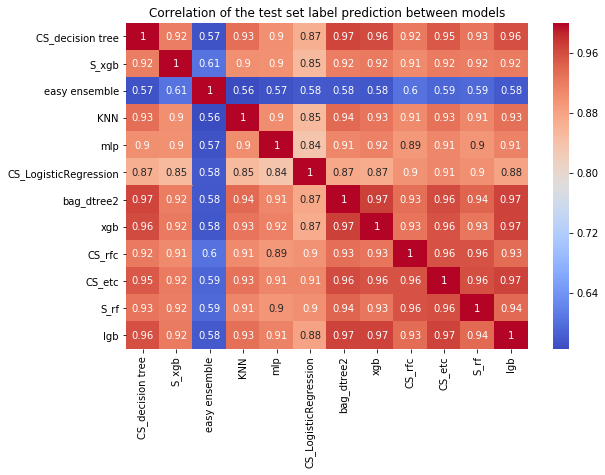

In [105]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [106]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [107]:
print("Least Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Least Absolute Correlations
easy ensemble     KNN              0.564784
                  mlp              0.571862
CS_decision tree  easy ensemble    0.572198
easy ensemble     xgb              0.575067
                  bag_dtree2       0.577977
dtype: float64


In [109]:
from sklearn.ensemble import VotingClassifier

In [110]:
#Top 5 Voting Classifier
vclf1 = VotingClassifier(estimators=
                              [('S_xgb', ogrid_xgb.best_estimator_), 
                               ('CS_etc', cgrid_cet.best_estimator_), 
                               ('CS_rfc', cgrid_crf.best_estimator_),
                               ('xgb', grid_xgb.best_estimator_),
                               ('S_rf', ogrid_rf.best_estimator_),
                               
                              ], )
vclf1_param = {
              'voting' : ['hard','soft'],
             }
vclf1_grid = GridSearchCV(vclf1, vclf1_param,cv=5, return_train_score=True,scoring=metric )
vclf1_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {vclf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {vclf1_grid.best_params_}')
print(f'Train score is {vclf1_grid.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.868811711423656
Best Mean Cross Validation Score is {'voting': 'soft'}
Train score is 0.9413707679603632


In [111]:
#Making predictions on test data
predictions_voting = vclf1_grid.predict(X_test)

In [112]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_voting}).to_csv('solution_filevoting.csv', index =False)  
print("Done :D")

Done :D


In [ ]:
#Making predictions on test data
predictions_stack4 = sclf1_grid.predict(X_test)

In [ ]:
#Exporting to excel file for submission 

pd.DataFrame({'Id': test.Id, 'Target': predictions_stack3}).to_csv('solution_filestack4.csv', index =False)  
print("Done :D")

In [115]:
#Stacking Top 5 Classifier

sclf1 = StackingClassifier(estimators=
                              [
                               ('S_xgb', ogrid_xgb.best_estimator_), 
                               ('CS_etc', cgrid_cet.best_estimator_), 
                               ('CS_rfc', cgrid_crf.best_estimator_),
                               ('bag_dtree2', bag_dtree2_grid.best_estimator_),
                               #('mlp', ogrid_mlp.best_estimator_),
                              ],final_estimator=LogisticRegression(random_state=42,max_iter=1000))

sclf1_param = {
             'final_estimator__C' : [0.1,1,10],
             'final_estimator__class_weight': [{0:1,1:10}, {0:1,1:100}],
              'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True,scoring=metric )
sclf1_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')

Best Mean Cross Validation Score is 0.8681808260527802
Best Mean Cross Validation Score is {'final_estimator__C': 10, 'final_estimator__class_weight': {0: 1, 1: 10}, 'stack_method': 'predict_proba'}
Train score is 0.9525756336876534
